# TP: Support Vector Machine (SVM)
#### Done by : IQBI Hamza & DARIA Taha

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from time import time
import pylab as pl

from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**Answer :**

The optimization problem of s soft margin SVM classifier is :

\begin{cases}
    \text{argmin}_{w \in H, w_0 \in \mathbb{R}, \xi \in \mathbb{R}^n} (\frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \xi_i) & \\
    \forall i, \xi_i \geq 0 & \\
    \forall i, \xi_i \geq 1 - y_i(w^T \Phi(x_i) + w_0)
\end{cases}

We use Lagrange multipliers to find a solution, and by Karush-Kuhn-Tucker conditions, we find that the optimal value 
$$\forall i, \alpha_i^{*}, \xi_i^{*} = 1 - y_i((w^{*})^T \Phi(x_i) + w_0^{*})$$

By replacing $\xi$ by its optimal value, we get that this optimization problem is equivalent to :
$$\text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right)$$


**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

**Answer :**

> An SVM minimizes the classification error using a convex upper bound

In the obtained form of the optimization problem we have, one can identifie a $L^2$ regularized minimization problem of a convex function. We have an upper bound since we penalize large values of $||w||$ (the bound is low for high values of C).

In fact, that is the difference between the pivotal loss (which is continuous and convex) and the loss of binary classification (which takes values in {0, 1}). 

Moreover, the hinge loss has a high penalization for missclassifications with high norm. 

## Example of using the SVC class from scikit-learn

In [2]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.9
Testing score : 0.8


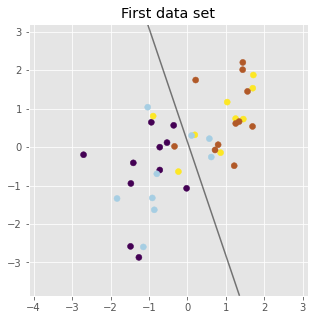

In [3]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

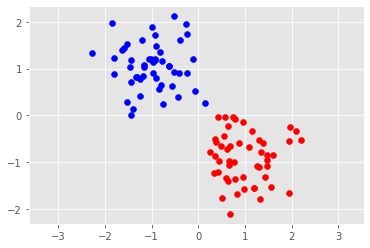

In [4]:
# Create two centers for the two distributions 
centers =  [[-1, 1], [1, -1]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples = 100, centers=centers, random_state=0, cluster_std=0.5)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [5]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
import random
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
# Repeat this n_mc times - enough to approximate 

n_mc = 100000
expectation = 0
for i in range(n_mc):
    # Random binary choice: will the point be generated from the first or second gaussian ? 
    rand = random.randint(0, 1)
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], cov = np.eye(2)*0.25)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], cov = np.eye(2)*0.25)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov = np.eye(2)*0.25)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov = np.eye(2)*0.25)
    # Compute the risk from these and add it to the total
    ratio = p1/(p1+p2)
    expectation += min(ratio, 1-ratio)

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.002
Estimated Bayes accuracy: 0.998


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 1.0/1.0


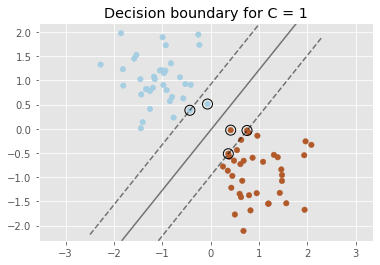

Train/Test scores: 1.0/1.0


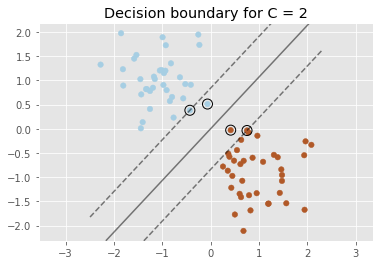

Train/Test scores: 1.0/1.0


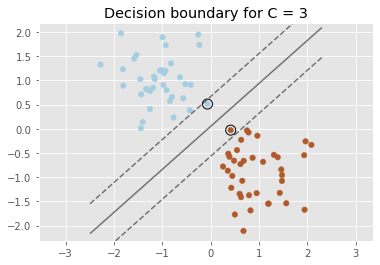

Train/Test scores: 1.0/1.0


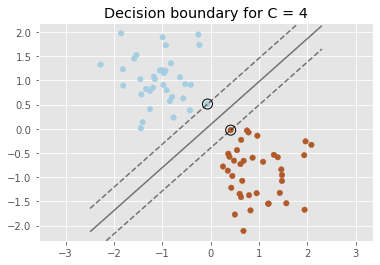

Train/Test scores: 1.0/1.0


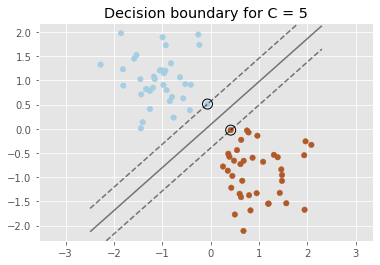

Train/Test scores: 1.0/1.0


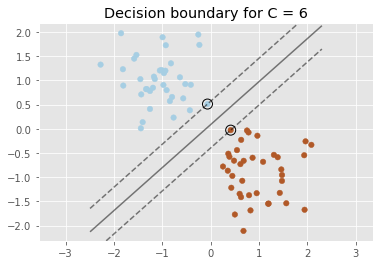

Train/Test scores: 1.0/1.0


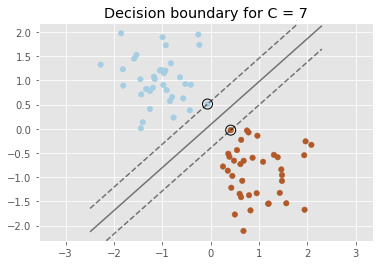

Train/Test scores: 1.0/1.0


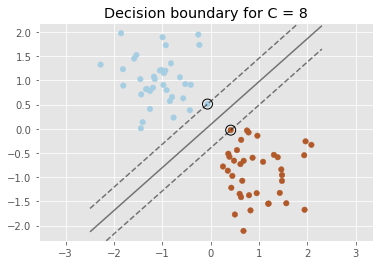

Train/Test scores: 1.0/1.0


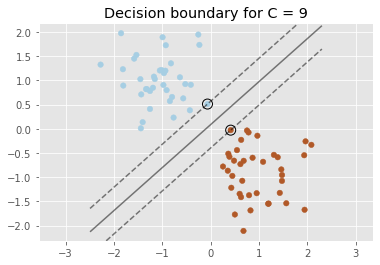

Train/Test scores: 1.0/1.0


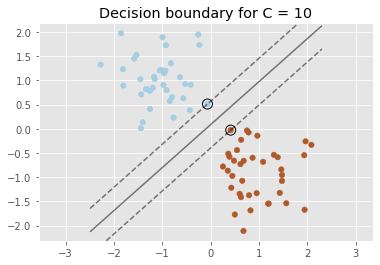

In [7]:
# Create a linear SVM and train it on the training data
for C in range(1, 11) :
    clf = SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)

    print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

    # Plot the data
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
    plt.title(f"Decision boundary for C = {C}")

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

    plt.axis('equal')
    plt.show()

**Comment :**

We have a score of 1 in both train and test sets because we have separable data (we have no misclassification). 

If we increase C, the size of the margin shrinks. For $C=4$, we have only one support vector from each class, therefore, even if we increase C furthermore, the result will not change and. We have fulfilled the principle of maximum minimum margin.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

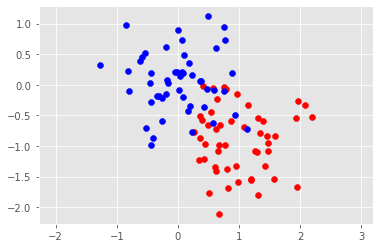

In [8]:
# Generate data and verify graphically that the two classes overlap

centers =  [[0, 0], [1, -1]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples = 100, centers=centers, random_state=0, cluster_std=0.5)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [9]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}

clf = GridSearchCV(SVC(), parameters, cv=5) 
clf.fit(X_train, y_train)
print(f'Best C: {clf.best_params_["C"]}')

Best C: 0.03162277660168379


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
for gamma in gammas:
    clf = SVC(kernel="rbf", gamma=gamma)
    clf.fit(X_train, y_train)
    print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

Train/Test scores: 1.0/0.96
Train/Test scores: 1.0/1.0
Train/Test scores: 1.0/1.0
Train/Test scores: 1.0/0.76


**Answer :**

$\gamma$ is a hyperparameter (as C) of the SVM model with Gaussian kernel, and its value can be tuned by a model selection technique (GridSearch, for example). But, tuning it on the training data can lead to overfitting : for example, when $\gamma = 100$, we have a Train score of $1$, and a test score of $0.76$. In other words, the model performs perfectly on the training data, but has weak generalization capacity.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

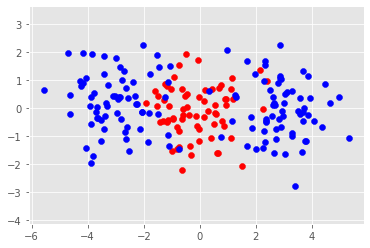

In [11]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 
centers = [[-3, 0], [0, 0], [3, 0]]    
X, y = make_blobs(n_samples = 200, n_features=3, centers=centers, random_state=0, cluster_std=1)

# Plot the points 
y[y == 2] = 0
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
clf_linear = GridSearchCV(SVC(), parameters, cv=5) 
clf_linear.fit(X_train, y_train)
print(f'Best C for linear kernel: {clf_linear.best_params_["C"]}')


Best C for linear kernel: 0.001


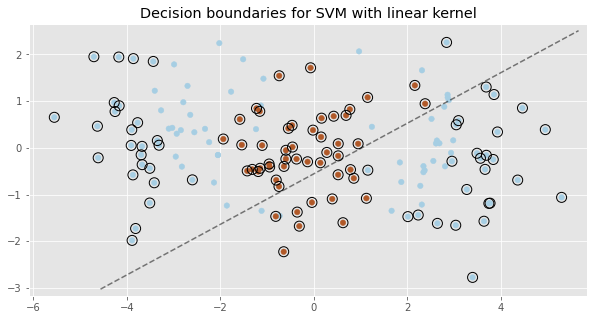

In [13]:
linear = SVC(kernel='linear', C = clf_linear.best_params_["C"])
linear.fit(X_train, y_train)

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_linear.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(linear.support_vectors_[:, 0], linear.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')


plt.axis('equal')
plt.title("Decision boundaries for SVM with linear kernel")
plt.show()

In [14]:
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5))}
clf_gaussian = GridSearchCV(SVC(), parameters, cv=5) 
clf_gaussian.fit(X, y)
print(f'Best C for gaussian kernel: {clf_gaussian.best_params_["C"]}')

Best C for gaussian kernel: 1.0


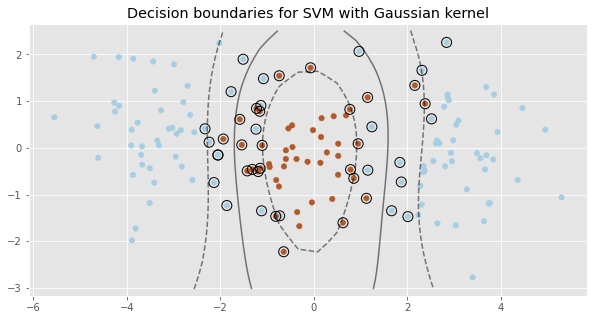

In [15]:
gaussian = SVC(kernel='rbf', C = clf_gaussian.best_params_["C"])
gaussian.fit(X_train, y_train)

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_gaussian.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(gaussian.support_vectors_[:, 0], gaussian.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.title("Decision boundaries for SVM with Gaussian kernel")
plt.show()

**Comment :**

As expected, by construction of the data, the linear kernel is not effective. And we can see that the Gaussian kernel works pretty well on this data, with some tolerated misclassifications, and convincing decision bounds.

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

In [17]:
# Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph.
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 500

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = SVC(kernel='rbf', C=1)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

In [18]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 

n_mc = 10000
expectation = 0
for i in range(n_mc):
    # Random binary choice: will the point be generated from the first or second gaussian ? 
    rand = random.randint(0, 2)
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], cov = np.eye(2))
    elif rand == 1:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], cov = np.eye(2))
    else :
        x = np.random.multivariate_normal(centers[2], cov = np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov = np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov = np.eye(2))
    p3 = multivariate_normal.pdf(x, mean=centers[2], cov = np.eye(2))
    # Compute the risk from these and add it to the total
    ratio_1 = p1/(p1+p2+p3)
    ratio_2 = p2/(p1+p2+p3)
    ratio_3 = p3/(p1+p2+p3)
    expectation += min(ratio_1, ratio_2, ratio_3)

expectation /= n_mc
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes accuracy: 0.999


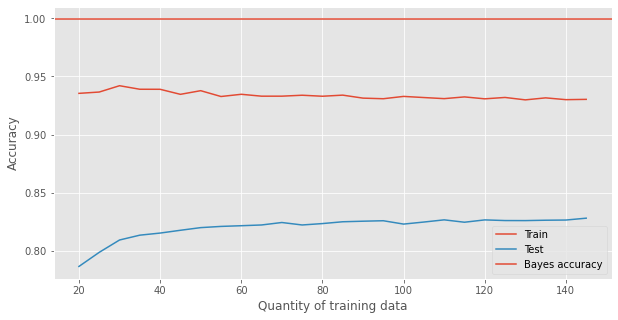

In [19]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

plt.figure(figsize=(10, 5))
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')
plt.axhline(y=1-expectation, linestyle='-', label='Bayes accuracy')

plt.legend()
plt.show()

**Comment :**

One can say that the accuracy tends to increase as the size of the training data increases. This is because having more data allows the algorithm to learn more robust and generalizable patterns, which can improve its performance on both the training and test data. In other words, as the algorithm is exposed to more examples, it can better capture the underlying structure of the data, leading to improved accuracy.


<div class='alert alert-block alert-warning'>
            Answer:</div>

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

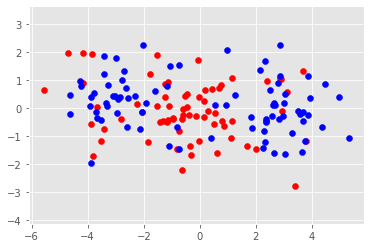

In [20]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

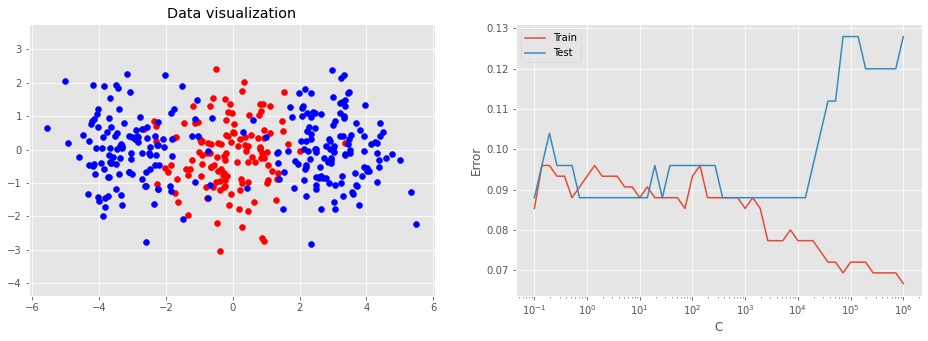

In [21]:
# Vary the appropriate parameter and plot the training/testing results

centers = [[-3, 0], [0, 0], [3, 0]]    
X, y = make_blobs(n_samples = 500, n_features=3, centers=centers, random_state=0, cluster_std=1)
y[y == 2] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

n_noise = 5
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].scatter(X_train[pos,0], X_train[pos,1], c='r')
axs[0].scatter(X_train[neg,0], X_train[neg,1], c='b')
axs[0].axis('equal')
axs[0].set_title('Data visualization')

C_range = np.logspace(-1, 6, 50)
error_train = []
error_test = []

for c in C_range:
    clf = SVC(kernel='rbf', C=c)
    clf.fit(X_train, y_train)
    error_train.append(1 - clf.score(X_train, y_train))
    error_test.append(1 - clf.score(X_test, y_test))

plt.plot(C_range, error_train, label='Train')
plt.plot(C_range, error_test, label='Test')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Error')

plt.legend()
plt.show()


**Answer :**

We can observe a divergence in the error for the train set and for the test set as C increases. this means that we have an overfitting for high values of C. This is normal since C contols the complexity of the model.

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [39]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/
"""

####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [44]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
Cs = np.logspace(-5, -1, 50) # No need to go for positive values of C, after the plot we have a constant value for the accuracy
accuracies = []
for C in Cs :
    clf = svm.SVC(kernel="linear", C = C)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    accuracies.append(clf.score(X_test, y_test))
    

Fitting the classifier to the training set


Text(0.5, 1.0, 'Accuracy of SVM classifier with Linear kernel on the test set')

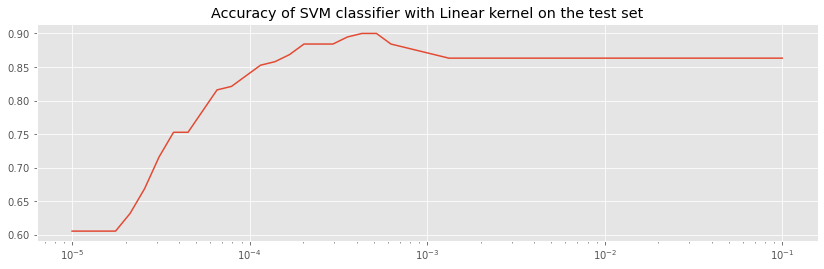

In [46]:
plt.figure(figsize=(14, 4))
plt.plot(Cs, accuracies)
plt.xscale('log')
plt.title("Accuracy of SVM classifier with Linear kernel on the test set")

In [51]:
print("Fitting the classifier to the training set")
t0 = time()

best_C = Cs[accuracies == max(accuracies)][0]

clf = svm.SVC(kernel="linear", C = best_C)
clf.fit(X_train, y_train)

# Predict labels for the X_test images with the best regularization parameter you obtained
print("Predicting the people names on the testing set")
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Fitting the classifier to the training set
Predicting the people names on the testing set
done in 0.278s
Chance level : 0.6210526315789474
Accuracy : 0.9


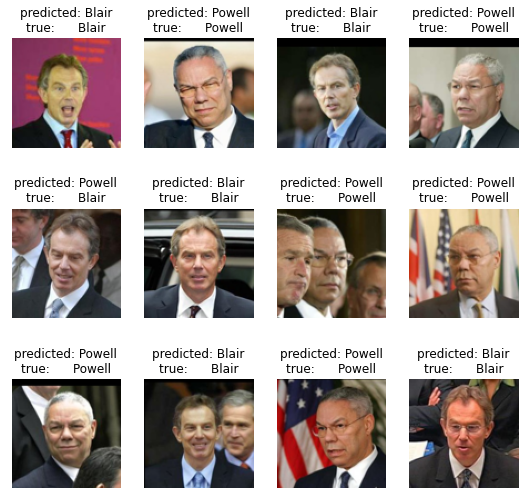

In [52]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

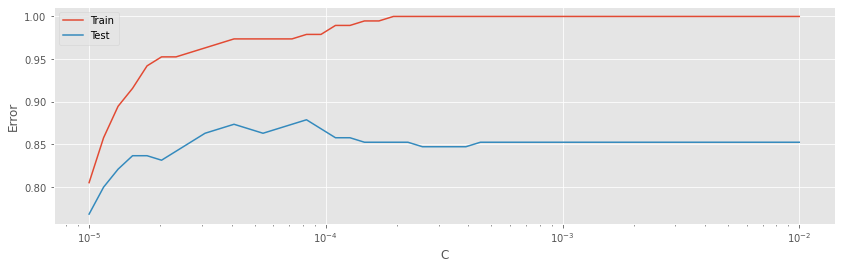

In [69]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values
X_train_noise, X_test_noise = X[train_idx, :], X[test_idx, :]
y_train_noise, y_test_noise = y[train_idx], y[test_idx]

n_noise = 5
n_tr = len(y_train_noise)
idx = np.random.choice(range(n_tr), n_noise)
y_train_noise[idx] = 1 - y_train_noise[idx]

# Create a figure with two subplots
plt.figure(figsize=(14, 4))

C_range = np.logspace(-5, -2, 50)
accuracy_train = []
accuracy_test = []

for c in C_range:
    clf = SVC(kernel='linear', C=c)
    clf.fit(X_train_noise, y_train_noise)
    accuracy_train.append(clf.score(X_train_noise, y_train_noise))
    accuracy_test.append(clf.score(X_test_noise, y_test_noise))

plt.plot(C_range, accuracy_train, label='Train')
plt.plot(C_range, accuracy_test, label='Test')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Error')

plt.legend()
plt.show()


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [73]:
accuracies = []
Cs = np.logspace(-5, 5, 50)
for C in Cs :
    clf = svm.SVC(kernel="rbf", C = C)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    accuracies.append(clf.score(X_test, y_test))

Text(0.5, 1.0, 'Accuracy of SVM classifier with Gaussian kernel on the test set')

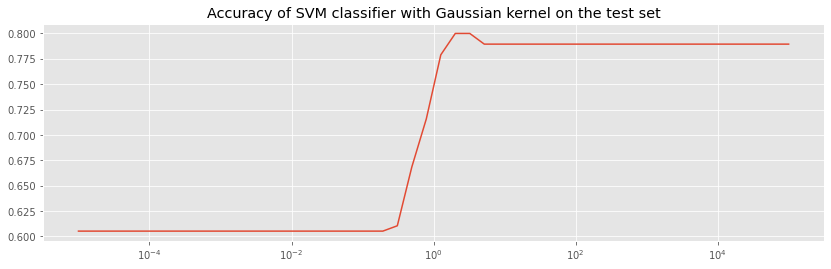

In [74]:
plt.figure(figsize=(14, 4))
plt.plot(Cs, accuracies)
plt.xscale('log')
plt.title("Accuracy of SVM classifier with Gaussian kernel on the test set")

In [79]:
clf = svm.SVC(kernel="rbf")
C_to_eval = np.logspace(-1, 3, num=10)
gamma_to_eval = np.logspace(-8, -6, num=10)
parameters = {'C': C_to_eval, 'gamma' : gamma_to_eval}
gs = GridSearchCV(clf, parameters, cv=5) 
gs.fit(X_train, y_train)

print(f'Best C for gaussian kernel: {gs.best_params_["C"]}')
print(f'Best gamma for gaussian kernel : {gs.best_params_["gamma"]}')
print(f'Best obtained score on test set : {gs.best_estimator_.score(X_test, y_test)}')


Best C for gaussian kernel: 359.38136638046257
Best gamma for gaussian kernel : 5.994842503189409e-07
Best obtained score on test set : 0.8526315789473684


Indeed, with an RBF kernel, the performance drops. It takes also more time compared to the linear kernel.

In [127]:
pca = PCA(n_components=75)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f' The explained variance by the kept components : {sum(pca.explained_variance_ratio_).round(4)}')

 The explained variance by the kept components : 0.9106


In [126]:
clf_pca = svm.SVC(kernel="rbf")
C_grid = np.logspace(-5, 5, num=50)
gamma_grid = np.logspace(-8, -5, num=50)
param_grid = {'C': C_grid, 'gamma': gamma_grid}
gs_pca = GridSearchCV(clf_pca, param_grid=param_grid, cv=5, n_jobs=-1)
gs_pca.fit(X_train_pca, y_train)

print(f'Best C for gaussian kernel: {gs_pca.best_params_["C"]}')
print(f'Best gamma for gaussian kernel : {gs_pca.best_params_["gamma"]}')
print(f'Best obtained score on test set : {gs_pca.best_estimator_.score(X_test_pca, y_test)}')

Best C for gaussian kernel: 54.286754393238596
Best gamma for gaussian kernel : 3.727593720314938e-06
Best obtained score on test set : 0.8631578947368421


The obtained socre after using PCA is slightly higher (not even significantly) than the one obtained directly by using SVM with Gaussian kernel. But it is much faster. 